Preamble and imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ridge regression and learning operators

You've likely encountered linear regression before in the context of fitting lines to data; it represents an interpretable "null hypothesis" model for finding trends in data. However, here we want to think a little more about how to interpret and understand linear regression, and so we will study a different context: learning approximate dynamical models directly from observations. 

### The vortex street revisited

We've already seen the von Karman vortex street in a previous homework assignment. This fluid flow corresponds a uniform flow moving over a cylinder. The velocity scale of this system, $U$, is set by the speed at which the fluid passes over the cylinder, while the length scale $L$ is the length of the cylinder. We normally see the vortex street instability first appear in the wake when $Re \gtrsim 100$. In our previous homework, we use a von Karman dataset comprising a series of snapshots of a two-dimensional velocity field, with separate datasets corresponding to different Reynolds numbers. 

We want to train a model that predicts the next snapshot of the flow field, $\mathbf{v}_{t+1}$, given only the current snapshot $\mathbf{v}_t$ as an input.
Our general learning problem has the form 
$$
\mathbf{v}(\mathbf{r})_{t + 1} = \mathbf{f}(\mathbf{v}(\mathbf{r})_{t})
$$
where $\mathbf{f}$ is the function that we are attempting to learn. While there are a variety of methods for learning the function $\mathbf{f}$, we will start by attempting to learn a linear model,
$$
\mathbf{v}(\mathbf{r})_{t + 1} = \boldsymbol{\theta} \cdot \mathbf{v}_{t}
$$
This problem is challenging because the Navier-Stokes equations are not linear in $\mathbf{v}$. In other words, by fitting a linear model to the snapshot time series, we attempt to approximate a highly nonlinear PDE with a linear model. We suspect that this approximation may work better over shorter timescales.

We can treat this problem as a regression problem, where our data matrix $X$ represents a stack of snapshots of the velocity field at different times, $X^T = [\mathbf{v}_1\;\mathbf{v}_2\;\cdots\mathbf{v}_{N-1}]$. While we are working with time series data, we will treat each snapshot as if it were an independent sample of a set of features---our regression results will be invariant to random shuffles of the input velocity field time series. In a more sophisticated approach, we might consider taking the ordering information into account in our regression. Our regression target, $Y$, represents the values of the velocity field at the next point in time, because our model will attempt to just predict the next step ahead in the process. For this reason, our labels or targets represent the matrix $Y^T = [\mathbf{v}_2\; \mathbf{v}_3\;\cdots\mathbf{v}_N]$. We emphasize that this regression problem is identical to standard linear regression, where we predict an outcome $y$ based on a set of input features $X$. Our forecasting problem is unique only in that $X$ and $Y$ happen to have the same dimensionality, since they are snapshots of a velocity field.

There's one hiccup in our approach: our input data is extremely high-dimensional. If we think of our input $X$ as a design matrix $X \in \mathbb{R}^{N_{data} \times N_{features}}$, then number of features is extremely large $N_{features} = 2 \cdot N_x \cdot N_y$, because we have x- and y- velocity components on each site of an $N_x \times N_y$ lattice. That means that we might find ourselves in the limit $N_{data} < N_{features}$, in which case the problem is underdetermined: there are multiple values of $\boldsymbol \theta$ that will maximize the accuracy of our model. As a tiebreaker, we will use the Ridge, or Tikhonov criterion: we select the solution parameter vector $\boldsymbol \theta$ with the lowest norm.

Putting our goals together, we arrive at a loss function describing the problem that we want to solve,
$$
\mathcal{L}(\boldsymbol{\theta}) = (X \boldsymbol{\theta} - \mathbf{y})^T(X \boldsymbol{\theta} - \mathbf{y}) + \lambda \boldsymbol{\theta}^T \boldsymbol{\theta}
$$
where the first term is proportional to the mean squared error, and $\lambda$ is a hyperparameter that determines how much we penalize the total weight vector. We wish to minimize this objective function with respect to the parameter matrix $\boldsymbol{\theta}$. This means that we want to solve the linear equation $\frac{\partial\mathcal{L}(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = 0$ for $\boldsymbol{\theta}$.  Note that while the loss function is a scalar, we are taking its derivative with respect to a tensor $\boldsymbol{\theta}$. After some linear algebra, we arrive at the following closed-form expression for the value of the weight vector
$$
\boldsymbol{\theta} = (X^T X + \lambda \mathbb{I})^{-1} X^T \;Y
$$
In the case $\lambda = 0$, our problem reduces to the ordinary least-squares (OLS) formula. In the case where we have large numbers of features, the ridge penalty is necessary to ensure that our problem has a unique solution. Even if $N_{samples} > N_{features}$, we might still prefer to use ridge regression to ordinary least squares, because ridge regression favors more parsimonious solutions, that avoid excessively weighting certain features.




## To Do

## Question: 

+ Starting from the optimality condition $\frac{\partial\mathcal{L}(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = 0$, derive the ridge regression formula shown above. You may find some of the linear algebra tricks we saw in the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) helpful here.

## Answer: 

$\frac{\partial \mathcal{L}}{\partial \theta_i} = X_{i,\cdot} ^T (X\theta - y) + (\theta^T X^T - y)X_{\cdot,i} - 2 \lambda \theta_i = 2 (\theta^T X^T - y)X_{\cdot,i} - 2 \lambda \theta_i = 0.$

$X_{i,\cdot} ^T (X\theta - y) - \lambda \theta_i = 0$

Expand the product and rearrange the terms,

$X_{i,\cdot} ^T X \theta - \lambda \theta_i = X_{i,\cdot} ^T y.$

The above equation equates the $i^{\rm th}$ entry of the vector on the l.h.s. to $i^{\rm th}$ entry of the vector on the r.h.s. Writing the same equation in the vector format and multiplying it by the pseudo-inverse of $(X^T X - \lambda)$ gives the desired result,

$X^T X \theta - \lambda \theta = X ^T y,$

$(X^T X - \lambda) \theta = X ^T y,$

$\theta = (X^T X - \lambda)^{-1} X ^T y.$


+ Implement a Ridge Regression model that predicts the next values of the Navier-Stokes equations. Below you will find three cells: one that loads the dataset, one that puts this dataset into a dataloader, and an unfinished class implementing Ridge regression. You only need to modify the RidgeRegression class, but you need to run the first two cells to load the data.
    +  Note: If you are working from a fork of the course repository, the dataset should load automatically. Otherwise, the firist cell below automatically downloads the datasets and places it in higher-level directory `../resources`. If the automatic download fails, you may need to manually download the [von Karman dataset](https://github.com/williamgilpin/cphy/blob/main/resources/von_karman_street/) and place it in the correct directory.
    + The `ForecastingDataset` class implemented below will store and feed the data to our regression model. This object will handle creating train/val/test splits for you. For now, just implement the "global" solution method to the ridge regression problem. You can implement an iterative solution if you want a more challenging problem. You may find the [Matrix Derivative Tutorial](https://github.com/williamgilpin/cphy/blob/main/talks/matrix_derivative.ipynb) helpful for the iterative solution.

## Question: 

+ You'll notice that my train/test split in the `ForecastingDataset` object ensures that the test data occurs after the training data in the time series, and that no data points are repeated. Why do you think this is important for this problem?

## Answer: 

My straightforward answer is to prevent data-leakage.

## Question: 
+ Our model has a single hyperparameter, the regularizer strength $\lambda$, that determines the degree to which the weight entries in the regression matrix are penalized. Using the validation fold of our training dataset, find the best value of that hyperparameter. You can find placeholder code for this below.

## Answer: 
$\lambda$ = 0.1

## Question:

+ Repeat your experiments using the von Karman datasets with different Reynolds numbers. How does forecast accuracy generally change with Reynolds number?

## Answer: 

+   The forecast accuracy becomes worse with increasing Reynolds number, primarily because the dynamics becomes chaotic and the number of features start to become uncorrelated with one another (almost by definition of what we mean by "chaos"), which in turn makes it hard to find a trend in the features.

## Question: 
+ There are plenty of other ways to solve a regression problem, besides ridge regression. In the last code cells below, we use implementations of several regression models included in the Python package `scikit-learn`. Check out how these models perform. Are there any surprises? Look up some background info on the models that seem to perform particularly well. Why do you think they work so well on this problem?

## Answer: 

+  The only surprise is how well the linear model does at capturing the details that you would only expect to uncover using the regression models in scikit-learn.

Found existing data file, skipping download.
Velocity field data has shape: (375, 128, 64, 2)


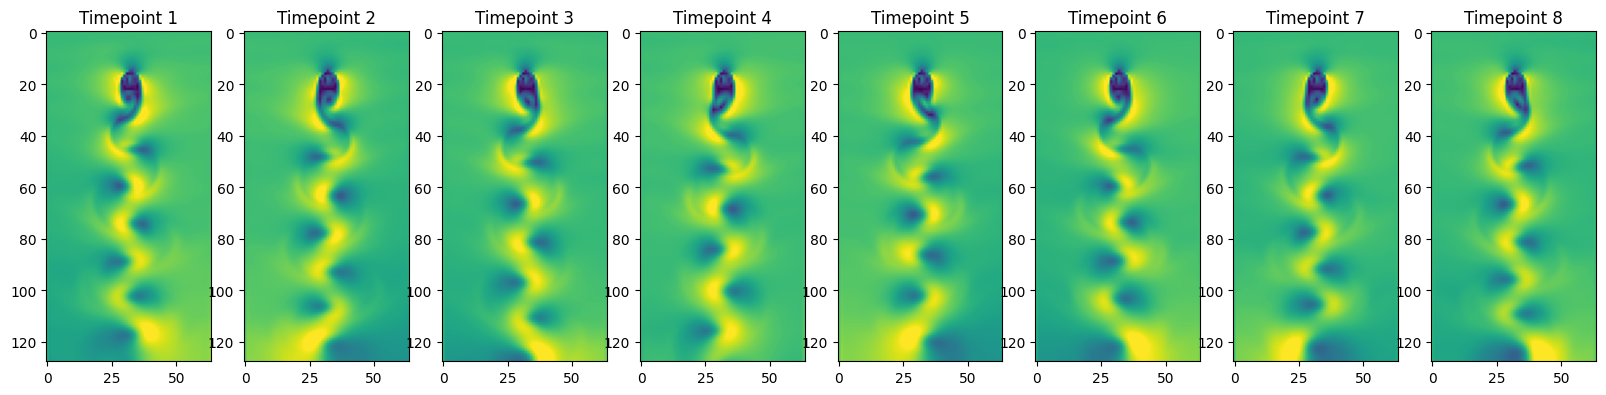

In [4]:
import os # Import the os module
import numpy as np # Import the numpy module
import urllib.request # Import requests module (downloads remote files)

Re = 300 # Reynolds number, change this to 300, 600, 900, 1200

fpath = f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}.npz"
if not os.path.exists(fpath):
    print("Data file not found, downloading now.")
    print("If this fails, please download manually through your browser")

    ## Make a directory for the data file and then download to it
    os.makedirs("../resources/von_karman_street/", exist_ok=True)
    url = f'https://github.com/williamgilpin/cphy/raw/main/resources/von_karman_street/vortex_street_velocities_Re_{Re}.npz'
    urllib.request.urlretrieve(url, fpath)
else: 
    print("Found existing data file, skipping download.")
vfield = np.load(fpath, allow_pickle=True) # Remove allow_pickle=True, as it's not a pickle file
print("Velocity field data has shape: {}".format(vfield.shape))

# Compute the velocity magnitude
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

n_tpts = vfield.shape[0]
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    v_vals = vfield_mag[n_tpts // 8 * i]
    plt.imshow(v_vals, cmap="viridis", vmin=0, vmax=np.percentile(v_vals, 99))
    plt.title("Timepoint {}".format(i + 1))

In [5]:
class ForecastingDataset:
    """
    A class for formatting time series data for forecasting.
    By convention, time is assumed to be the first dimension of the dataset.

    For time series data, it is very important that all data in test set is after 
    all data in the train and val sets. We also need to ensure that datapoints don't
    appear in multiple splits. 

    Parameters
        X (np.ndarray): The time series data. The first dimension is assumed to be time.
        split_ratio (tuple): The ratio of the data to be used for train, val, and test.
        forecast_horizon (int): The number of time steps to forecast at once
        featurizer (callable): A function that takes in multivariate snapshot and 
            returns a feature vector. If None, the raw data is used.
    """

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1, featurizer=None):

        if featurizer is None:
            self.featurizer = lambda x: x
        else:
            self.featurizer = featurizer

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = self.featurizer(X[:-1])#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], # 1 - 600, 2 - 601 | 601 - 800
            self.y_full[n_train+ forecast_horizon:n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X_full)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out


# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover
import unittest
class TestForecastingDataset(unittest.TestCase):

    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"

    # test split_size

unittest.main(argv=[''], exit=False);



.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Implement the Ridge regression model

In [6]:
import numpy as np
import warnings
import matplotlib.pyplot as plt


class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        raise NotImplementedError("Subclasses must implement this method")

    def score(self, X, y):
        """
        Returns the mean squared error of the model.
        """
        return np.mean((self.predict(X) - y)**2)




class LinearRegressor(BaseRegressor):
    """
    A linear regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn

    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.

    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization="ridge", regstrength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention.
    # Technically we could access them from outside the class, but we should
    # not do that because they can be changed or removed at any time.
    def _fit_global(self, X, y):
        """
        Fits the model using the global least squares method.
        """
        if self.regularization is None:
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        elif self.regularization == "ridge":
            self.weights = np.linalg.inv(X.T @ X + np.eye(X.shape[1]) * self.regstrength) @ X.T @ y
        else:
            warnings.warn("Unknown regularization method, defaulting to None")
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        self.bias = np.mean(y - X @ self.weights)
        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        """
        Fit the model using gradient descent.
        """
        self.weights = np.zeros((X.shape[1], X.shape[1]))
        self.bias = np.mean(y)
        for i in range(X.shape[0]):
            self.weights += learning_rate * (y[i] - X[i] @ self.weights - self.bias) * X[i] - self.regstrength * self.weights
        self.weights /= X.shape[0]
        return self.weights, self.bias

    def fit(self, X, y):
        """
        Fits the model to the data. The method used is determined by the
        `method` attribute.
        """
        if self.method == "global":
            out = self._fit_global(X, y)
        elif self.method == "iterative":
            out = self._fit_iterative(X, y)
        else:
            out = self._fit_global(X, y)
        return out

    def predict(self, X):
        return X @ self.weights + self.bias




### Test your solution

+ You don't need to write any new code below here. This is all to test your solution and study its properties.
+ If you are working from a local fork of the entire course, then you already have access to the solutions. In this case, make sure to `git pull` to make sure that you are up-to-date (save your work first).
+ If you are working from a single downloaded notebook, or are working in Google Colab, then you will need to manually download the solutions file from the course repository. The lines below will do this for you.

Text(0.5, 0, 'Time step')

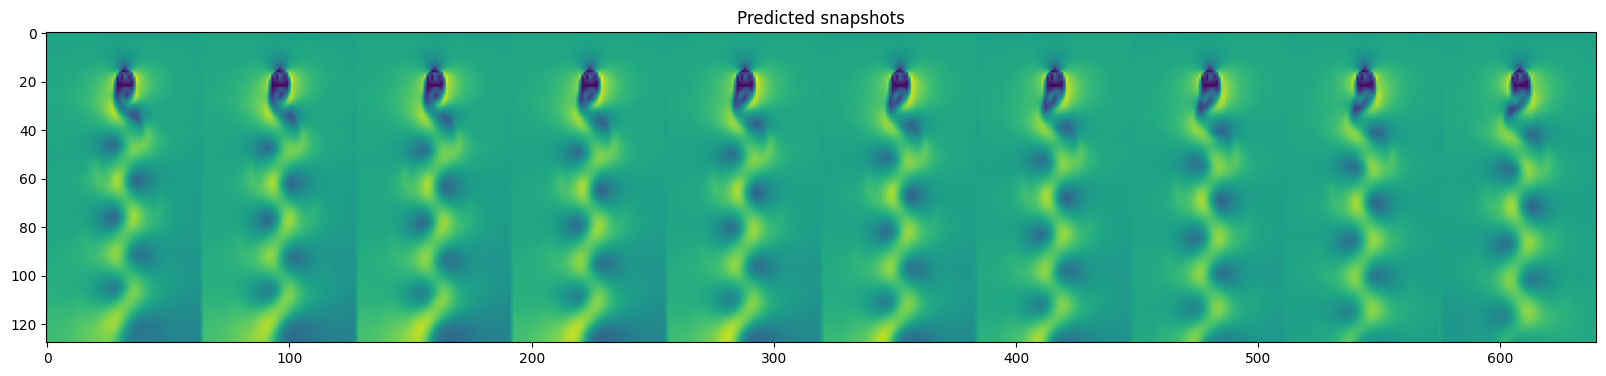

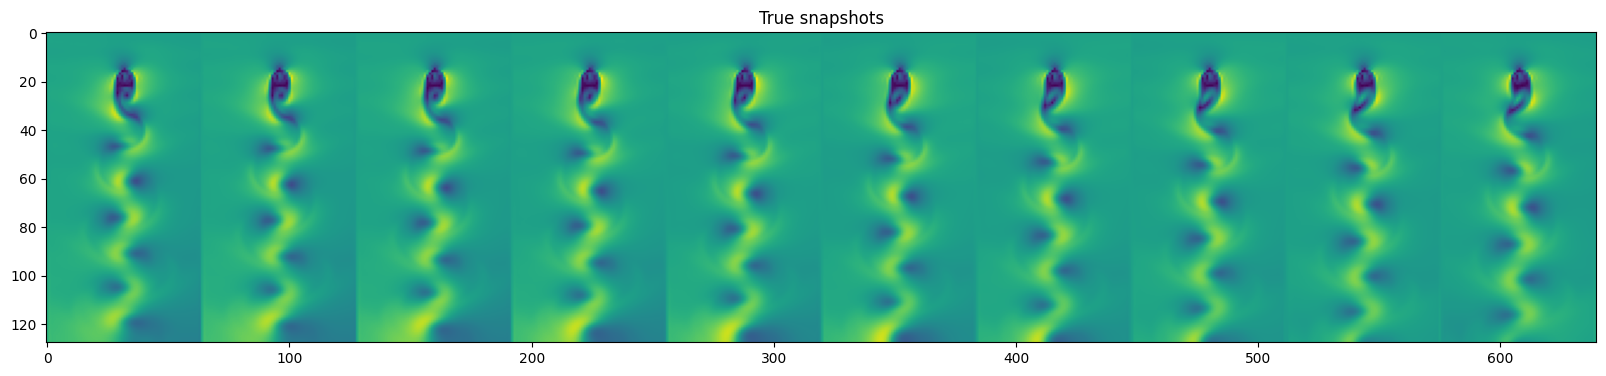

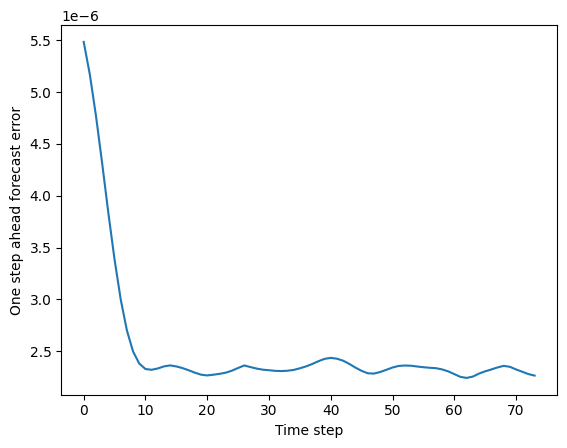

In [8]:
# Import William's solution
# from solutions.linear_regression import LinearRegressor

# Automatically split the data into train, validation, and test sets
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=1.0)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")


### Perform hyperparameter tuning

Using the validation fold of the von Karman dataset, find the best value of the ridge penalty hyperparameter $\lambda$

In [9]:
## Set the range of regularizer strengths that we want to check
regstrengths = np.logspace(-4, 4, 9)

all_mse = []
for regstrength in regstrengths:
    print(f"Training model with regstrength={regstrength}", flush=True)

    model = LinearRegressor(method="global", regularization="ridge", regstrength=regstrength)

    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_val_pred = dataset.unflatten_data(
        model.predict(dataset.flatten_data(dataset.X_val))
    )

    mse = np.mean((y_val_pred - dataset.y_val)**2)
    all_mse.append(mse)

best_regstrength = regstrengths[np.argmin(np.array(all_mse))]

print(f"Best regularize strength: {best_regstrength}")


Training model with regstrength=0.0001
Training model with regstrength=0.001
Training model with regstrength=0.01
Training model with regstrength=0.1
Training model with regstrength=1.0
Training model with regstrength=10.0
Training model with regstrength=100.0
Training model with regstrength=1000.0
Training model with regstrength=10000.0
Best regularize strength: 0.1


Text(0.5, 0, 'Time step')

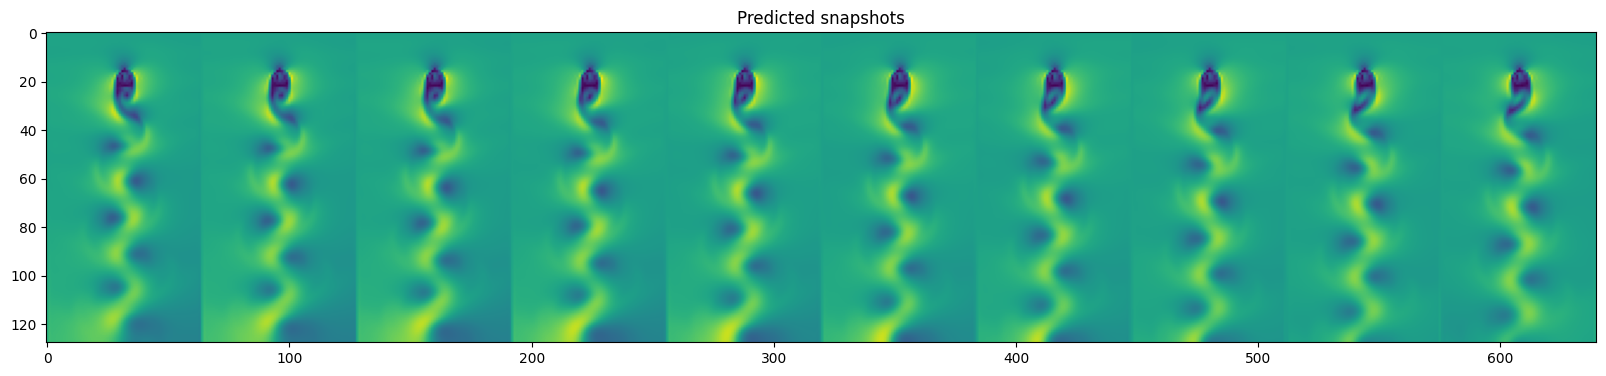

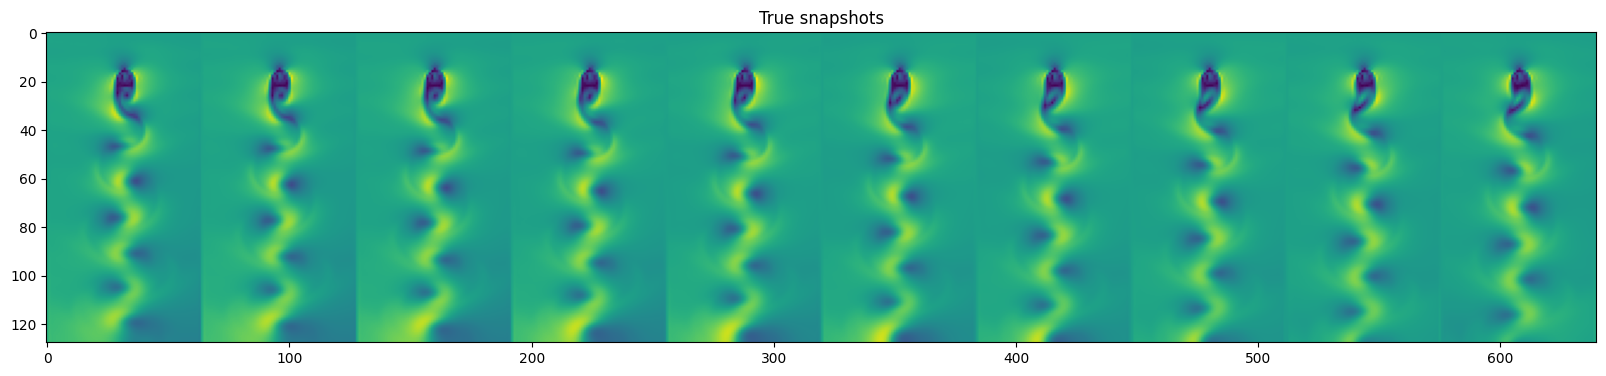

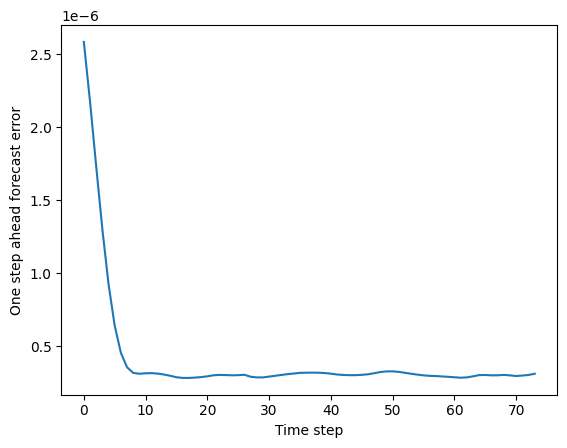

In [10]:
model = LinearRegressor(method="global", regularization="ridge", regstrength=best_regstrength)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")

mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")



## Appendix: The Navier-Stokes equations

The Navier-Stokes equations comprise a set of partial differential equations describing the evolution of a velocity field $\mathbf{u}$,
$$
\rho\left(\dfrac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u}       \right) = -\nabla p + \mu \nabla \cdot \left(    (\nabla \mathbf{u} + (\nabla \mathbf{u})^T) - \dfrac{2}{3} (\nabla \cdot \mathbf{u})\mathbf{I}          \right) + \mathbf{F}
$$
This equation describes several interacting phenomena. The first parenthetical term proportional to the local density $\rho$ corresponds to inertial forces, while the second term corresponds to pressure gradients in the fluid. The term proportional to the viscousity, $\rho$, represents the effect of viscous drag within the fluid, while the forcing term $\mathbf F$ corresponds to external forces.

We usually supplement this partial differential equation with an additional equation describing conservation of momentum,
$$
\dfrac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{v}) = 0.
$$
Note that the full Navier-Stokes equations describe the dynamical evolution of three coupled fields: the velocity field $\mathbf{u}$, the local density $\rho$, and the pressure $p$. Usually, we will not attempt to directly solve the full equations, but instead we will first reduce these equations to a more specific form based on constraints or symmetries relevant to a specific problem. For example, when working with water or other liquids we usually assume the incompressibility condition $\nabla \rho = \mathbf{0}$, $\nabla \cdot \mathbf{u} = 0$.

We will assume that we are working with an incompressible fluid with no body forces ($\mathbf{F}=0$). If our flow has a characteristic length scale $L$ and velocity scale $U$, we can non-dimensionalize the Navier-Stokes equations by performing the substitution $\mathbf{u} \leftarrow \mathbf{u} / U$, $\mathbf{r} \leftarrow \mathbf{r} / L$, $\nabla \leftarrow L \nabla$, $t \leftarrow t (U / L)$, $p \leftarrow p / (\rho U^2)$, producing the non-dimensionalized Navier-Stokes equations
$$
{\frac {\partial \mathbf {u} }{\partial t}}+(\mathbf {u} \cdot \nabla)\mathbf {u} \ =-\nabla p+{\frac {1}{Re}}\nabla^{2}\mathbf {u}.
$$
where we have used the identities $\nabla \cdot (\nabla \cdot \mathbf {u} )\mathbf {I} =\nabla (\nabla \cdot \mathbf {u} )$ and $\nabla \cdot (\nabla \mathbf{u})^T = \nabla(\nabla \cdot \mathbf{u})$

The non-dimensional Reynolds number is defined as $Re \equiv \rho U L / \mu$. The Reynolds number quantifies the ratio of inertial to viscous forces in the system. At large $Re$, the advective terms dominate the Navier-Stokes equations, while the Laplacian term associated with dissipation vanishes. The resulting inertia-dominated equations, known as the Euler equation for ideal (frictionless) fluids, give rise to turbulence in fast-moving classical fluids at large length scales (the Euler equation also approximates the dynamics of superfluids, for similar reasons). At very small $Re$, however, friction dominates the system, leading to the Stokes equations. This overdamped dynamical regime describes [many biological systems](http://www.damtp.cam.ac.uk/user/gold/pdfs/purcell.pdf), and it [many counterintuitive phenomena](https://www.youtube.com/watch?v=UpJ-kGII074) arise due to the appearance of time-reversal symmetry in the underlying equations.
